In [1]:
import os
import sys

import torch
from torch.utils.data import DataLoader
from torchvision.models import resnet18

from sklearn.metrics import confusion_matrix
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("/home/self_supervised_learning_gr/self_supervised_learning/dev/ProjetCassiopee")
from src.setup import setup_python, setup_pytorch
from src.transformation.custom_crop import ObjectCrop
from src.dataset import RGBDObjectDataset, RGBDObjectDataset_Supervised_Contrast
from src.models.rgbd_object.cnn import TestCNN, TestSmallerCNN, test

/home/self_supervised_learning_gr/self_supervised_learning/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
setup_python()

In [3]:
DEVICE = setup_pytorch()

In [4]:
BATCH_SIZE = 10 # Batch size
INPUT_SIZE = (256,256)
TRANSFORMATION = None
CROP_TRANSFORMATION = ObjectCrop(output_size=INPUT_SIZE,
                                 padding=(20,20),
                                 offset_range=(-10,10))
NB_MAX_TEST_SAMPLES = 1000

test_dataset = RGBDObjectDataset(path="../../../data/RGB-D_Object/rgbd-dataset",
                                 mode="test",
                                 transformation=TRANSFORMATION,
                                 crop_transformation=CROP_TRANSFORMATION,
                                 nb_max_samples=NB_MAX_TEST_SAMPLES)

test_data_loader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [5]:
# model = TestCNN().to(DEVICE)

# model = TestSmallerCNN().to(DEVICE)

model = resnet18()
model.fc = torch.nn.Linear(512, len(test_dataset.class_dict), bias=True)

In [6]:
weight_path = "cnn_20240403_141634/weights_epoch_1_batch_6000"
model.load_state_dict(torch.load(weight_path))
model = model.to(DEVICE)

In [7]:
# Test
all_label, all_predicted = test(model,
                                test_data_loader,
                                DEVICE)

Test:       accuracy=0.93400000


In [13]:
# Accuracy
total = len(all_label)
correct = (all_predicted == all_label).sum().item()
accuracy = correct / total
print(f"Test: accuracy = {accuracy}")

Test: accuracy = 0.934


In [12]:
# Micro F1 score
micro_f1_score = multiclass_f1_score(all_predicted, all_label, num_classes=torch.unique(all_label).shape[0], average="micro")
print(f"Test: micro_f1_score = {micro_f1_score}")

# Macro F1 score
macro_f1_score = multiclass_f1_score(all_predicted, all_label, num_classes=torch.unique(all_label).shape[0], average="macro")
print(f"Test: macro_f1_score = {macro_f1_score}")

# Weighted F1 score
weighted_f1_score = multiclass_f1_score(all_predicted, all_label, num_classes=torch.unique(all_label).shape[0], average="weighted")
print(f"Test: weighted_f1_score = {weighted_f1_score}")

# F1 score
f1_score = multiclass_f1_score(all_predicted, all_label, num_classes=torch.unique(all_label).shape[0], average=None)
print(f"Test: f1_score = {f1_score}")

Test: micro_f1_score = 0.9340000748634338
Test: macro_f1_score = 0.9236884117126465
Test: weighted_f1_score = 0.9335028529167175
Test: f1_score = tensor([0.6667, 0.9825, 1.0000, 0.8108, 1.0000, 0.6250, 1.0000, 0.8000, 0.9600,
        0.9000, 0.7273, 0.8444, 1.0000, 0.9333, 0.9524, 1.0000, 0.9608, 0.9524,
        0.9474, 0.8837, 0.9583, 1.0000, 1.0000, 1.0000, 0.9846, 1.0000, 0.9778,
        0.8800, 0.8276, 0.8966, 0.9524, 0.9474, 0.9778, 0.9375, 1.0000, 0.9000,
        0.8889, 1.0000, 0.6383, 0.9524, 0.8889, 0.9375, 0.9474, 0.9231, 0.8947,
        1.0000, 0.9474, 0.9863, 0.9412, 0.9756, 1.0000])


<Axes: >

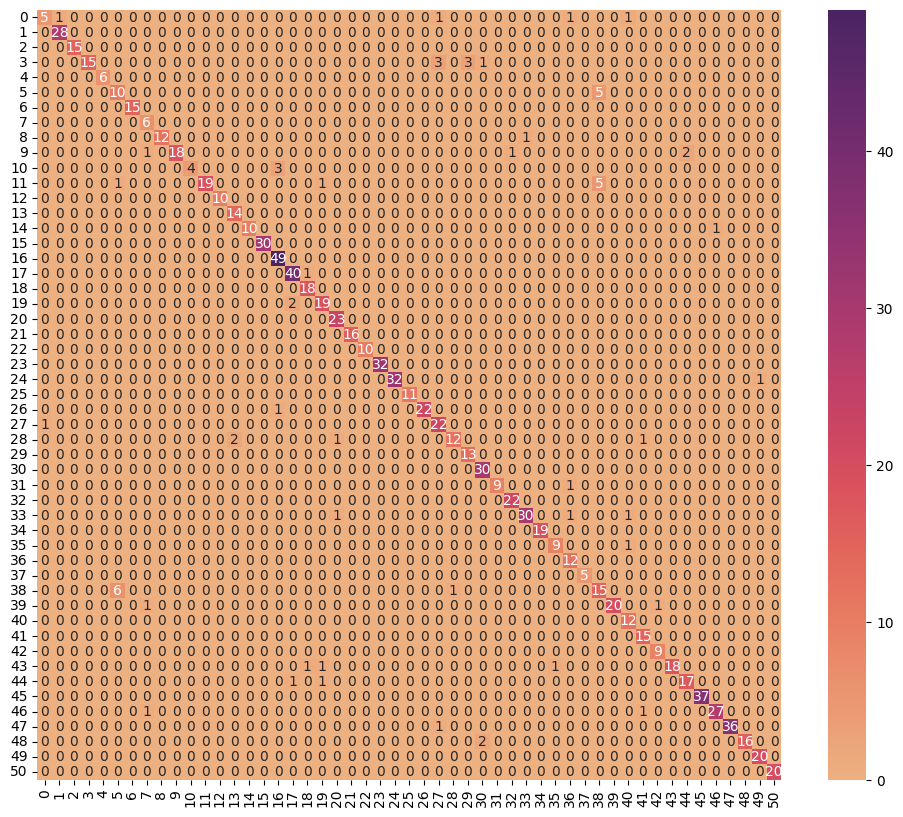

In [10]:
# Confusion Matrix
test_confusion_matrix = confusion_matrix(all_label, all_predicted)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(test_confusion_matrix, annot=True, cmap="flare",  fmt="d", cbar=True, ax=ax)

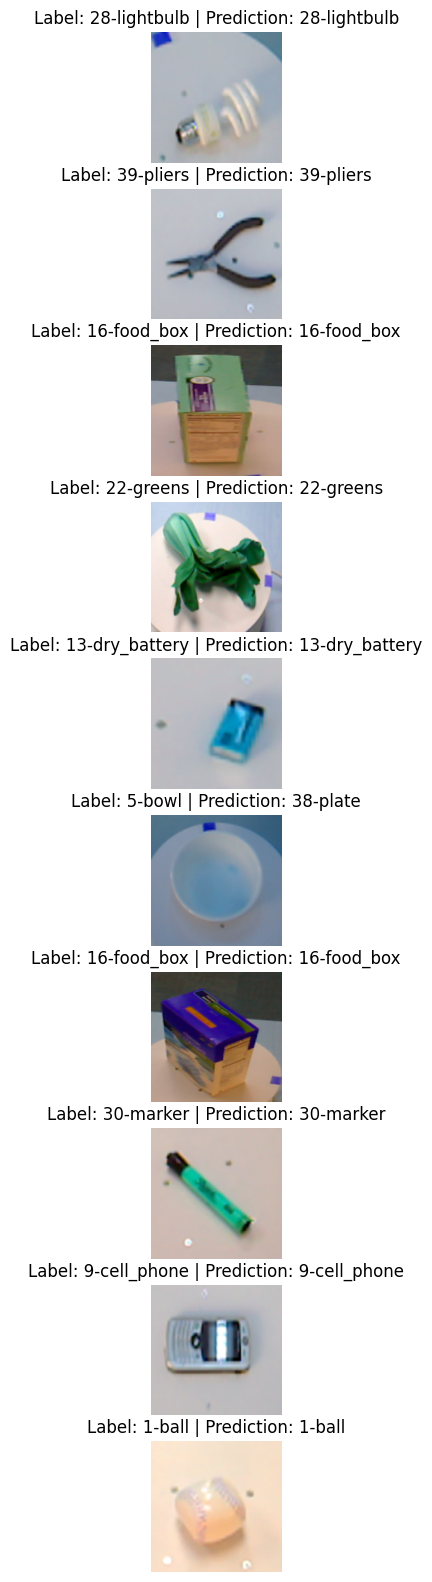

In [11]:
with torch.no_grad():
    # Retrieve batch data
    batch = next(iter(test_data_loader))

    # Load and prepare batch
    rgb, depth, mask, loc_x, loc_y, label = batch
    rgb = rgb.to(DEVICE)
    # depth = depth.to(DEVICE)
    # mask = mask.to(DEVICE)
    # loc_x = loc_x.to(DEVICE)
    # loc_y = loc_y.to(DEVICE)
    label = label.to(DEVICE)
        
    # Make predictions for batch
    output = model(rgb)
    _, predicted = torch.max(output.data, 1)

    fig, axs = plt.subplots(BATCH_SIZE, 1, figsize=(4, 20))
    for i in range(BATCH_SIZE):
        rgb_, label_, predicted_ = rgb[i], label[i], predicted[i]
        rgb_, label_, predicted_ = rgb_.cpu(), label_.cpu(), predicted_.cpu()
        
        axs[i].imshow(rgb_.permute(1, 2, 0))
        axs[i].set_title(f"Label: {label_}-{list(test_dataset.class_dict)[label_]} | Prediction: {predicted_}-{list(test_dataset.class_dict)[predicted_]}")
        axs[i].set_axis_off()
    plt.show()